In [1]:
%matplotlib inline
import os, sys
import numpy as np
import scipy.io as sio
from collections import Counter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import cv2
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import matplotlib.image as mpimg
import imageio
import h5py
import random
from PIL import Image
import json
from astropy.modeling.models import Gaussian2D
from numpy.random import randint
from matplotlib import animation
import time
from numpy.linalg import norm

<font color='red'> The bounding box is as follows:[min_x,min_y,max_x,max_y]

# Evaluate estimated 2D poses

<font color='red'> Transform to single cropped image coordinate system

In [16]:
def show_2d(img, points, c="g"):
    for j in range(J):
        cv2.circle(img, (int(points[j, 0]), int(points[j, 1])), 3, c, -1)
    for e in edges:
        cv2.line(
            img,
            (int(points[e[0], 0]), int(points[e[0], 1])),
            (int(points[e[1], 0]), int(points[e[1], 1])),
            c,
            2,
        )
    return img

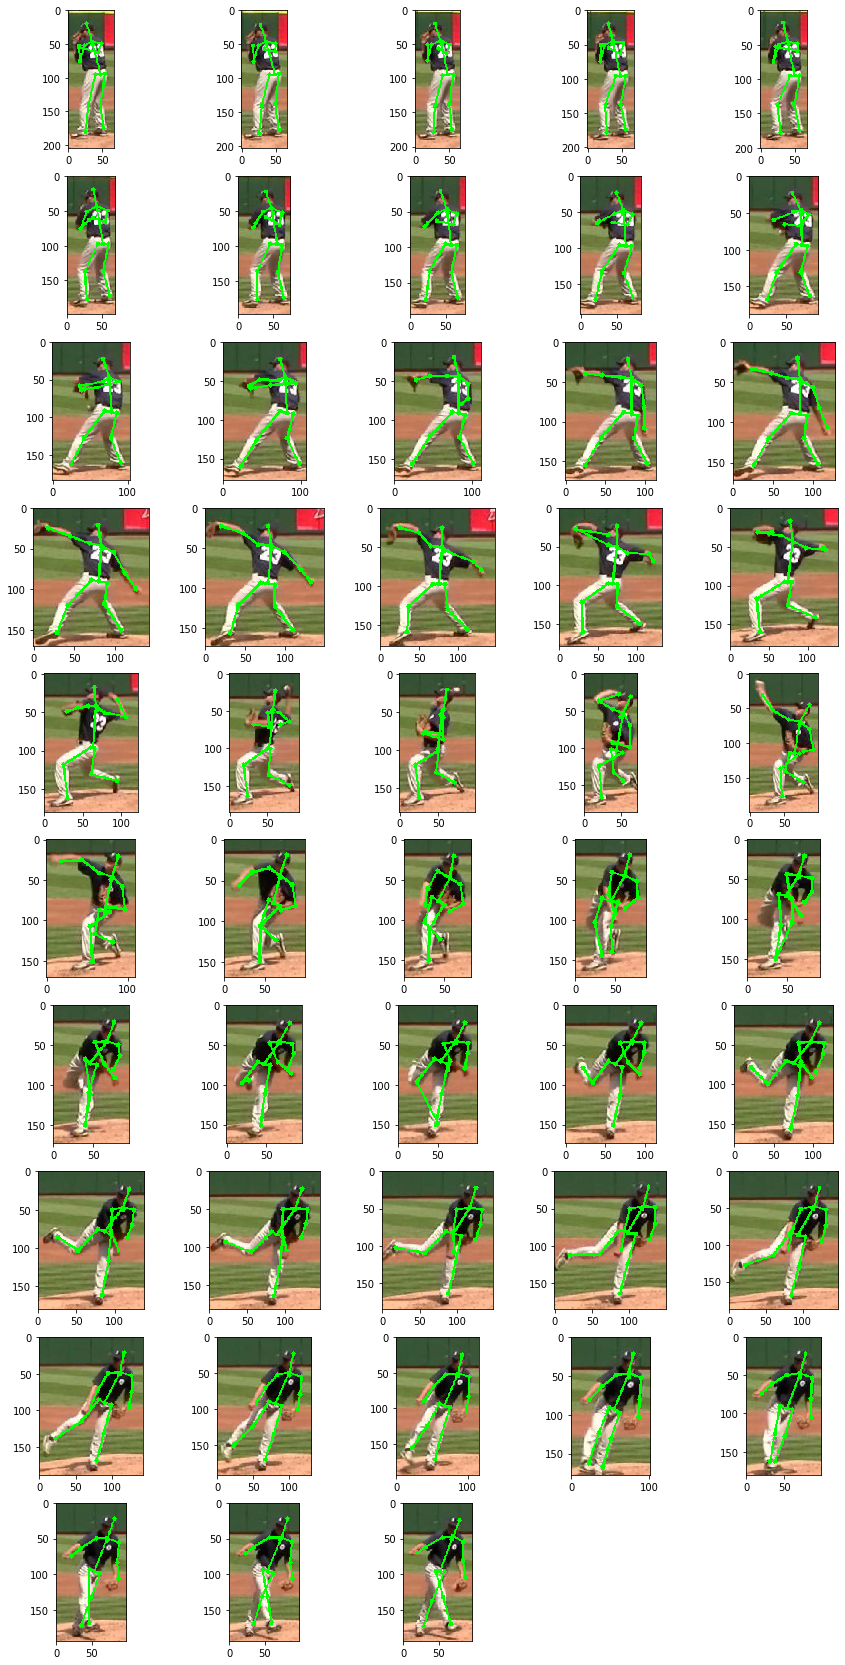

In [18]:
J = 16
edges = [
    [0, 1],
    [1, 2],
    [2, 6],
    [6, 3],
    [3, 4],
    [4, 5],
    [10, 11],
    [11, 12],
    [12, 8],
    [8, 13],
    [13, 14],
    [14, 15],
    [6, 8],
    [8, 9],
]
EDGE = 10
OutputRes = 256

preds = h5py.File("../tmp/0005.h5")
annots = sio.loadmat("../tmp/0005.mat")
dir_frame = "../tmp/0005"
frames = sorted(os.listdir(dir_frame))
keys = sorted(preds.keys())
bboxes = annots["bbox"].astype(np.int32)

count = 0
fig = plt.figure(figsize=(15, 30))
if bboxes.shape[0] == len(keys) and len(keys) == len(frames):
    # get global bounding box
    nFrame = len(keys)
    dimensions = annots["dimensions"][0][:2]
    global_min_x = max(0, min(bboxes[:, 0] - EDGE))
    global_min_y = max(0, min(bboxes[:, 1] - EDGE))
    global_max_x = min(max(bboxes[:, 2] + EDGE), dimensions[1])
    global_max_y = min(max(bboxes[:, 3] + EDGE), dimensions[0])

    for i in range(nFrame):
        # get scale and transformations
        shift_x = 0
        shift_y = 0
        min_x = max(0, bboxes[i, 0] - EDGE)
        min_y = max(0, bboxes[i, 1] - EDGE)
        max_x = min(bboxes[i, 2] + EDGE, dimensions[1])
        max_y = min(bboxes[i, 3] + EDGE, dimensions[0])
        h = max_y - min_y
        w = max_x - min_x
        size = max(h, w)
        scale = size / OutputRes
        paddings = int(abs(h - w) / 2)
        if h >= w:
            shift_x -= paddings
        else:
            shift_y -= paddings

        pred_joints = np.array(preds[keys[i]]).astype(np.float32)
        pred_joints *= scale
        pred_joints[:, 0] += shift_x
        pred_joints[:, 1] += shift_y

        path_images = os.path.join(dir_frame, keys[i])
        img = plt.imread(path_images)
        img = show_2d(img, pred_joints, c=(0, 255, 0))
        if count < 50:
            plt.subplot(10, 5, count + 1)
            plt.imshow(img.astype(np.int32))
            count += 1

# Evaluate coordinates transformation

<font color='red'> Transform to global coordinate system of single video. Notice that the predictions have 3 columns, the first column is along horizontal x axis. 

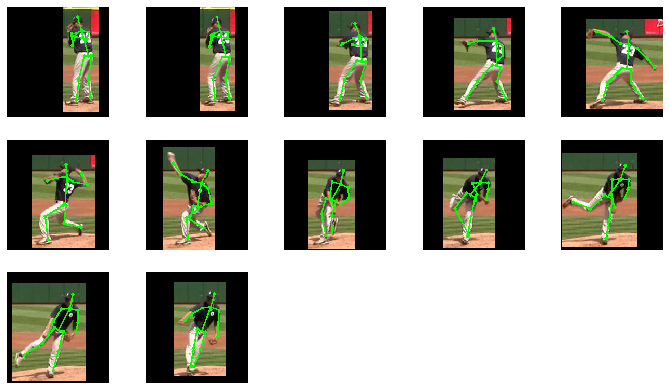

In [24]:
J = 16
edges = [
    [0, 1],
    [1, 2],
    [2, 6],
    [6, 3],
    [3, 4],
    [4, 5],
    [10, 11],
    [11, 12],
    [12, 8],
    [8, 13],
    [13, 14],
    [14, 15],
    [6, 8],
    [8, 9],
]
EDGE = 10
OutputRes = 256

preds = h5py.File("../tmp/0005.h5")
annots = sio.loadmat("../tmp/0005.mat")
dir_frame = "../tmp/0005"
frames = sorted(os.listdir(dir_frame))
keys = sorted(preds.keys())
bboxes = annots["bbox"].astype(np.int32)

count = 0
fig = plt.figure(figsize=(12, 24))
if bboxes.shape[0] == len(keys) and len(keys) == len(frames):
    # get global bounding box
    nFrame = len(keys)
    dimensions = annots["dimensions"][0][:2]
    global_min_x = max(0, min(bboxes[:, 0] - EDGE))
    global_min_y = max(0, min(bboxes[:, 1] - EDGE))
    global_max_x = min(max(bboxes[:, 2] + EDGE), dimensions[1])
    global_max_y = min(max(bboxes[:, 3] + EDGE), dimensions[0])

    for i in range(nFrame):
        # get scale and transformations
        shift_x = 0
        shift_y = 0
        min_x = max(0, bboxes[i, 0] - EDGE)
        min_y = max(0, bboxes[i, 1] - EDGE)
        max_x = min(bboxes[i, 2] + EDGE, dimensions[1])
        max_y = min(bboxes[i, 3] + EDGE, dimensions[0])
        h = max_y - min_y
        w = max_x - min_x
        size = max(h, w)
        scale = size / OutputRes
        paddings = int(abs(h - w) / 2)
        if h >= w:
            shift_x -= paddings
        else:
            shift_y -= paddings

        left = min_x - global_min_x
        right = global_max_x - max_x
        upper = min_y - global_min_y
        lower = global_max_y - max_y

        shift_x += left
        shift_y += upper

        path_images = os.path.join(dir_frame, keys[i])
        img = plt.imread(path_images)
        img_padded = np.zeros(
            (global_max_y - global_min_y, global_max_x - global_min_x, 3)
        )
        for p in range(3):
            img_padded[:, :, p] = np.pad(
                img[:, :, p], ((upper, lower), (left, right)), "constant"
            )

        pred_joints = np.array(preds[keys[i]]).astype(np.float32)
        pred_joints *= scale
        pred_joints[:, 0] += shift_x
        pred_joints[:, 1] += shift_y

        img = show_2d(img_padded, pred_joints, c=(0, 255, 0))
        if count < 50 and count % 4==0:
            plt.subplot(10, 5, count/4 + 1)
            plt.imshow(img.astype(np.int32))
            plt.axis("off")
        count += 1

# Evaluate estimated 2D PoTion

<font color='red'> The ground truth PoTion representation is continuous

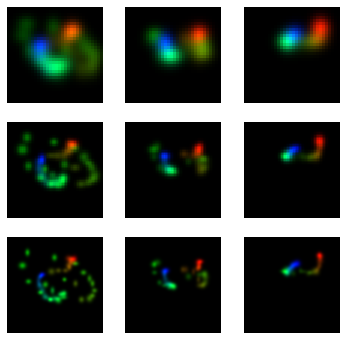

In [10]:
potion = np.load("../potion/pred-32/0005.npy")
plt.figure(figsize=(6, 6))
for i in range(3):
    ind=(i+10)*3
    plt.subplot(3,3,i+1)
    plt.imshow(potion[:,:,ind:ind+3])
    plt.axis('off')

potion = np.load("../potion/pred-64/0005.npy")
for i in range(3):
    ind=(i+10)*3
    plt.subplot(3,3,i+4)
    plt.imshow(potion[:,:,ind:ind+3])
    plt.axis('off')
    
potion = np.load("../potion/pred-96/0005.npy")
for i in range(3):
    ind=(i+10)*3
    plt.subplot(3,3,i+7)
    plt.imshow(potion[:,:,ind:ind+3])
    plt.axis('off')

In [ ]:
pred_potion = np.load("../potion/pred-64/0005.npy")
plt.figure(figsize=(12, 6))
for i in range(12,16):
    ind=i*3
    plt.subplot(2,4,(i-12)+1)
    plt.imshow(pred_potion[:,:,ind:ind+3])
plt.axis('off')

In [ ]:
pred_potion = np.load("../potion/pred-96/0005.npy")
plt.figure(figsize=(12, 6))
for i in range(12,16):
    ind=i*3
    plt.subplot(2,4,(i-12)+1)
    plt.imshow(pred_potion[:,:,ind:ind+3])
plt.axis('off')

# Evaluate estimated 3D PoTion

<font color='red'> It takes around 67MB to store a 3D PoTion with shape of [64,64,64,64]. It has 64 channels and Resolution is 64. The channel is the last dim.

In [2]:
## define global variables
NUM_JOINT = 16
EDGE = 10
OutputRes = 256
RESOLUTION = 64
HEIGHT = 64
DEPTH = 64
WIDTH = 64
C = 3
partition = {}
partition["train"] = []
partition["test"] = []
labels = {}

<IPython.core.display.Javascript object>

In [3]:
"""
input:
    data_matrix: non-negative heat map of each joint, in shape [n_frames, n_joints, x, y, z_depth]
    channel: required channel number, e.g., 2,3,4,5...
output:
    potion: Potion matrix in shape [n_joints, n_channel, x, y, z_depth]
"""


def get_potion_from3D(data_matrix, channel):
    time_interval_T = data_matrix.shape[0]
    potion = []

    for i in range(0, data_matrix.shape[1]):
        # init
        curr_joint = data_matrix[:, i, :, :, :]
        [ori_time_t, x, y, z] = curr_joint.shape

        curr_Potion = np.zeros([channel, x, y, z])

        # slit the time_interval_T into (channel - 1) subsections
        time_arr = np.arange(1, time_interval_T, (time_interval_T - 1) / (channel - 1))
        # add the time_interval_T itself
        time_arr = np.append(time_arr, time_interval_T)

        for T in range(1, time_interval_T):
            index = 0

            # get the subsections (index) where the current time lies
            for k in np.nditer(time_arr):
                if T < k:
                    break
                index += 1

            # calculate the clip of the original time series
            time_original = round(ori_time_t / time_interval_T * T)

            # update Potion representation, where index - 1 = [1 - (t-1)/(T-1)] and index = [(t-1)/(T-1)]
            curr_Potion[index - 1, :, :, :] += curr_joint[time_original, :, :, :] * (
                1 - (T - time_arr[index - 1]) / (time_arr[index] - time_arr[index - 1])
            )

            curr_Potion[index, :, :, :] += curr_joint[time_original, :, :, :] * (
                (T - time_arr[index - 1]) / (time_arr[index] - time_arr[index - 1])
            )

        # the data from time T is added to the last channel
        curr_Potion[-1, :, :, :] += curr_joint[-1, :, :, :]

        # normalize each channel
        for i_channel in range(np.shape(curr_Potion)[0]):
            curr_Potion[i_channel, :, :, :] = curr_Potion[i_channel, :, :, :] / (
                sys.float_info.epsilon + np.max(curr_Potion[i_channel, :, :, :])
            )

        potion.append(curr_Potion)

    return np.array(potion)


"""
input:
    Potion: Potion matrix in shape [n_joints, channel, x, y, z_depth]

output:
    r_Intensity: Intensity matrix in shape [n_joints, x, y, z_depth]
"""


def get_intensity_from3D(Potion):
    intensity = []
    for i in range(0, Potion.shape[0]):
        curr_potion = Potion[i, :, :, :, :]
        curr_Intensity = np.zeros(
            [curr_potion.shape[1], curr_potion.shape[2], curr_potion.shape[3]]
        )
        for i_channel in range(np.shape(curr_potion)[0]):
            curr_Intensity += curr_potion[i_channel, :, :, :]
        intensity.append(curr_Intensity)
    return np.array(intensity)


"""
input:
    Potion: Potion matrix in shape [n_joints, channel, x, y, z_depth]
    Intensity: Intensity matrix in shape [n_joints, x, y, z_depth]

output:
    r_Normalized: Normalized matrix in shape [n_joints, channel, x, y, z_depth]
"""


def get_normalized_from3D(Potion, Intensity):
    normalized = []

    for i in range(0, Potion.shape[0]):
        curr_potion = Potion[i, :, :, :, :]
        curr_intensity = Intensity[i, :, :, :]

        curr_normalized = np.zeros(curr_potion.shape)
        #         hyperparameter, original set to 1
        epsilon = 1
        for i_channel in range(np.shape(curr_normalized)[0]):
            curr_normalized[i_channel, :, :, :] = curr_potion[i_channel, :, :, :] / (
                epsilon + curr_intensity
            )

        normalized.append(curr_normalized)

    return np.array(normalized)


"""
Stack three representations and resize to the given shape
Potion: [n_joints, channel, height, width]
Intensity: [n_joints, height, width]
Normalized_potion: [n_joints, channel, height, width]
"""


def get_descriptor(heatmaps, C):
    potion = get_potion_from3D(heatmaps, C)
    intensity = get_intensity_from3D(potion)
    potion = np.reshape(
        potion,
        (
            potion.shape[0] * potion.shape[1],
            potion.shape[2],
            potion.shape[3],
            potion.shape[4],
        ),
    )
    descriptor = np.vstack((potion, intensity))
    return descriptor


"""
Get 3d heatvolume
"""


def get_heatvolume(amplitude, center_x, center_y, center_z, resolution):
    axis = np.linspace(0, resolution - 1, resolution)
    x = axis[:, None, None] - center_x
    y = axis[None, :, None] - center_y
    z = axis[None, None, :] - center_z
    sigma_square = 2.25
    heat_volume = (
        np.exp(-(x ** 2 + y ** 2 + z ** 2) / (2.0 * sigma_square))
        / (np.sqrt(2.0 * np.pi * sigma_square))
        * amplitude
    )
    return heat_volume.astype(np.float32)

<IPython.core.display.Javascript object>

In [4]:
t0 = time.clock()
crn_label = sio.loadmat("tmp/0005.mat")  # store the label, isTrain, bboxes
crn_preds = h5py.File(
    "tmp/0005.h5"
)  # dictionary, filename is the key. each value is an array of shape 16x3

# get isTrain, bounding box, label, #frames
bboxes = crn_label["bbox"].astype(np.int32)

# keys of the crn_preds
all_keys = sorted(crn_preds.keys())

if bboxes.shape[0] == len(
    all_keys
):  # in some cases, there are mismatching and is wired
    # get global bounding box
    dimensions = crn_label["dimensions"][0][:2]
    global_min_x = max(0, min(bboxes[:, 0] - EDGE))
    global_min_y = max(0, min(bboxes[:, 1] - EDGE))

    # transform each frame within the same video to the global coordinate system
    nFrames = len(all_keys)
    joints_x = np.zeros((nFrames, NUM_JOINT))
    joints_y = np.zeros((nFrames, NUM_JOINT))
    joints_z = np.zeros((nFrames, NUM_JOINT))
    for nframe in range(nFrames):
        crn_joints = np.array(crn_preds[all_keys[nframe]]).astype(
            np.float32
        )  # 16x3 array
        # get transformation scale and shifts along x and y axis
        shift_x = 0
        shift_y = 0
        min_x = max(0, bboxes[nframe, 0] - EDGE)
        min_y = max(0, bboxes[nframe, 1] - EDGE)
        max_x = min(bboxes[nframe, 2] + EDGE, dimensions[1])
        max_y = min(bboxes[nframe, 3] + EDGE, dimensions[0])
        h = max_y - min_y
        w = max_x - min_x
        size = max(h, w)
        scale = size / OutputRes
        paddings = int(abs(h - w) / 2)
        if h >= w:
            shift_x -= paddings
        else:
            shift_y -= paddings

        left = min_x - global_min_x
        upper = min_y - global_min_y

        shift_x += left
        shift_y += upper

        # apply transformations 0:along horizontal x     1: along vertical y
        crn_joints *= scale
        crn_joints[:, 0] += shift_x
        crn_joints[:, 1] += shift_y

        joints_x[nframe] = crn_joints[:, 0]
        joints_y[nframe] = crn_joints[:, 1]
        joints_z[nframe] = crn_joints[:, 2]

    # normalize the joints to the desired height and width of the heatmap
    min_joints_x = np.min(joints_x) - 5
    min_joints_y = np.min(joints_y) - 5
    min_joints_z = np.min(joints_z) - 5
    max_joints_x = np.max(joints_x) + 5
    max_joints_y = np.max(joints_y) + 5
    max_joints_z = np.max(joints_z) + 5

    scale_x = WIDTH / (max_joints_x - min_joints_x)
    scale_y = HEIGHT / (max_joints_y - min_joints_y)
    scale_z = DEPTH / (max_joints_z - min_joints_z)

    min_scale = min(scale_x, scale_y, scale_z)

    normalized_x = (joints_x - min_joints_x) * min_scale
    normalized_y = (joints_y - min_joints_y) * min_scale
    normalized_z = (joints_z - min_joints_z) * min_scale

    normalized_x = normalized_x.astype(np.int32)
    normalized_y = normalized_y.astype(np.int32)
    normalized_z = normalized_z.astype(np.int32)

    # get heatvolumns
    heatmaps = np.zeros((nFrames, NUM_JOINT, HEIGHT, WIDTH, DEPTH))

    # generate ramdom sigma
    rand_amplitudes = randint(33, 37, NUM_JOINT * nFrames) / 100
    ind = 0
    for i in range(nFrames):
        for j in range(NUM_JOINT):
            heatmaps[i, j, :, :, :] = get_heatvolume(
                rand_amplitudes[ind],
                normalized_x[i, j],
                normalized_y[i, j],
                normalized_z[i, j],
                RESOLUTION,
            )
            ind += 1
    # get descriptor
    descriptor = get_descriptor(heatmaps, C).astype("float32")

    # keras take channel last
    descriptor = np.moveaxis(descriptor, 0, -1)
#     np.save('3d_potion.npy',descriptor)
t1 = time.clock()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


<IPython.core.display.Javascript object>

In [6]:
print(t1 - t0)

5.077598999999999


<IPython.core.display.Javascript object>

In [8]:
normalized_coordinates = np.zeros((3, nFrames, NUM_JOINT))
normalized_coordinates[0] = normalized_x
normalized_coordinates[1] = normalized_y
normalized_coordinates[2] = normalized_z
np.save("tmp/coor.npy", normalized_coordinates)

<IPython.core.display.Javascript object>

In [206]:
potion_3d = np.load("tmp_data/3d/0005.npy")
print(potion_3d.shape)
print(np.max(potion_3d), np.min(potion_3d))

(64, 64, 64, 64)
1.9893318 0.0


<IPython.core.display.Javascript object>

{(23, 31, 21): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x126edc0b8>,
 (23, 32, 21): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x126edc390>,
 (23, 34, 20): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x126edc5c0>,
 (24, 30, 21): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x126edc7f0>,
 (24, 31, 20): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x126edca20>,
 (24, 31, 21): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x126edcc50>,
 (24, 32, 21): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x126edce80>,
 (24, 34, 21): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x126fee0f0>,
 (25, 31, 19): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x126fee320>,
 (25, 31, 20): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x126fee550>,
 (26, 36, 21): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x126fee780>,
 (26, 39, 20): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x126fee9b0>,
 (27, 31, 20): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x126feebe0>,

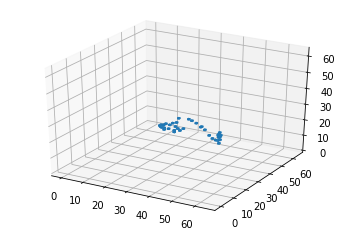

<IPython.core.display.Javascript object>

In [227]:
plt.Figure(figsize=(12, 12))
nFrames = normalized_x.shape[0]
i = 2
locations = np.zeros((RESOLUTION, RESOLUTION, RESOLUTION), dtype=np.int32)
x = normalized_x[:, i]
y = normalized_y[:, i]
z = normalized_z[:, i]
for j in range(nFrames):
    locations[x[j], y[j], z[j]] = 1
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.voxels(locations)

# 2D pose estimation accuracy

<font color='red'> Find the mapping from predicted 16 joints to ground truth 13 joints

In [22]:
def show_2d(img, points, c="g"):
    for j in range(points.shape[0]):
        cv2.circle(img, (int(points[j, 0]), int(points[j, 1])), 3, c, -1)
    return img

<IPython.core.display.Javascript object>

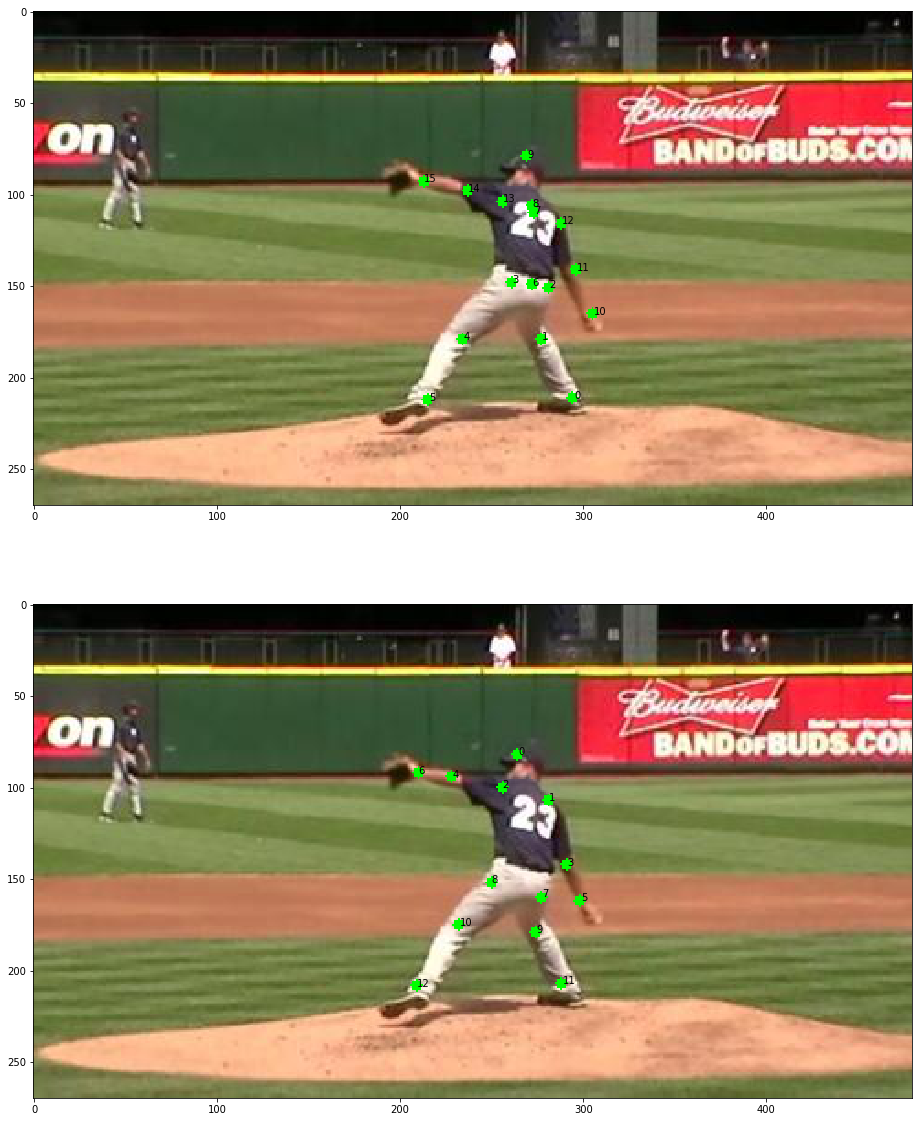

<IPython.core.display.Javascript object>

In [32]:
prediction = h5py.File("PennAction/pred/0005.h5")
label = sio.loadmat("PennAction/labels/0005.mat")
img = plt.imread("PennAction/frames/0005/000015.jpg")
EDGE = 10
OutputRes = 256
if len(prediction.keys()) == label["bbox"].shape[0]:
    # get global bounding box
    bboxes = label["bbox"].astype(np.int32)
    dimensions = label["dimensions"][0][:2]
    global_min_x = max(0, min(bboxes[:, 0] - EDGE))
    global_min_y = max(0, min(bboxes[:, 1] - EDGE))
    nFrames = len(prediction.keys())
    nframe = 14
    crn_joints = np.array(prediction["000015.jpg"]).astype(np.float32)  # 16x3 array
    shift_x = 0
    shift_y = 0
    min_x = max(0, bboxes[nframe, 0] - EDGE)
    min_y = max(0, bboxes[nframe, 1] - EDGE)
    max_x = min(bboxes[nframe, 2] + EDGE, dimensions[1])
    max_y = min(bboxes[nframe, 3] + EDGE, dimensions[0])
    h = max_y - min_y
    w = max_x - min_x
    size = max(h, w)
    scale = size / OutputRes
    paddings = int(abs(h - w) / 2)
    if h >= w:
        shift_x -= paddings
    else:
        shift_y -= paddings

    left = min_x - global_min_x
    upper = min_y - global_min_y

    shift_x += left
    shift_y += upper

    # apply transformations 0:along horizontal x     1: along vertical y
    crn_joints *= scale
    crn_joints[:, 0] += shift_x
    crn_joints[:, 1] += shift_y
    crn_joints[:, 0] += global_min_x
    crn_joints[:, 1] += global_min_y

    # plot estimation and ground truth
    pred = crn_joints[:, :2]
    gt = np.array([label["x"][14], label["y"][14]]).T

    img2 = img.copy()
    img1 = show_2d(img, pred, c=(0, 255, 0))
    img2 = show_2d(img2, gt, c=(0, 255, 0))

    fig = plt.figure(figsize=(30, 20))
    plt.subplot(2, 1, 1)
    plt.imshow(img1.astype(np.int32))
    for i in range(pred.shape[0]):
        plt.text(pred[i, 0], pred[i, 1], str(i))

    plt.subplot(2, 1, 2)
    plt.imshow(img2.astype(np.int32))
    for i in range(gt.shape[0]):
        plt.text(gt[i, 0], gt[i, 1], str(i))

<font color='red'> The corresponding sequence is [9,12,13,11,14,10,15,2,3,1,4,0,5]

In [5]:
dict_action = {
    "baseball_pitch": 1,
    "clean_and_jerk": 2,
    "pull_up": 3,
    "pullup": 3,
    "strumming_guitar": 4,
    "strum_guitar": 4,
    "baseball_swing": 5,
    "golf_swing": 6,
    "push_up": 7,
    "pushup": 7,
    "tennis_forehand": 8,
    "bench_press": 9,
    "jumping_jacks": 10,
    "sit_up": 11,
    "situp": 11,
    "tennis_serve": 12,
    "bowl": 13,
    "jump_rope": 14,
    "squats": 15,
    "squat": 15,
}

In [6]:
DIR_PRED = "../pennAction/pred"
DIR_LABEL = "../pennAction/labels"
pred_files = os.listdir(DIR_PRED)
label_files = os.listdir(DIR_LABEL)
EDGE = 10
OutputRes = 256
SEQUENCE = [9, 12, 13, 11, 14, 10, 15, 2, 3, 1, 4, 0, 5]
assert len(pred_files) == len(label_files)
file_names = [ele.split(".")[0] for ele in pred_files]
mjec = {}
for i in range(1, 16):
    mjec[i] = []
for eachfile in file_names:
    prediction = h5py.File(os.path.join(DIR_PRED, eachfile + ".h5"))
    label = sio.loadmat(os.path.join(DIR_LABEL, eachfile + ".mat"))
    if len(prediction.keys()) == label["bbox"].shape[0]:
        # get global bounding box
        bboxes = label["bbox"].astype(np.int32)
        dimensions = label["dimensions"][0][:2]
        global_min_x = max(0, min(bboxes[:, 0] - EDGE))
        global_min_y = max(0, min(bboxes[:, 1] - EDGE))
        nFrames = len(prediction.keys())

        # process the prediction of each frame
        mean_errors = []
        for nframe in range(nFrames):
            crn_joints = np.array(prediction[sorted(prediction.keys())[nframe]]).astype(
                np.float32
            )  # 16x3 array
            shift_x = 0
            shift_y = 0
            min_x = max(0, bboxes[nframe, 0] - EDGE)
            min_y = max(0, bboxes[nframe, 1] - EDGE)
            max_x = min(bboxes[nframe, 2] + EDGE, dimensions[1])
            max_y = min(bboxes[nframe, 3] + EDGE, dimensions[0])
            h = max_y - min_y
            w = max_x - min_x
            size = max(h, w)
            scale = size / OutputRes
            paddings = int(abs(h - w) / 2)
            if h >= w:
                shift_x -= paddings
            else:
                shift_y -= paddings

            left = min_x - global_min_x
            upper = min_y - global_min_y

            shift_x += left
            shift_y += upper

            # apply transformations 0:along horizontal x     1: along vertical y
            crn_joints *= scale
            crn_joints[:, 0] += shift_x
            crn_joints[:, 1] += shift_y
            crn_joints[:, 0] += global_min_x
            crn_joints[:, 1] += global_min_y

            # compare with the ground truth
            pred = crn_joints[SEQUENCE, :2]
            gt = np.array([label["x"][nframe], label["y"][nframe]]).T
            errors = pred - gt
            mean_error = np.mean(norm(errors, axis=1))
            mean_errors.append(mean_error)
        errors = np.array(mean_errors)
        mean_error = np.mean(errors)
        label = dict_action[label["action"][0]]
        mjec[label].append(mean_error)

In [7]:
for i in range(1, 16):
    print(np.mean(mjec[i]))

15.288706758107896
21.781545960121147
35.991359233253526
135.32937091714834
11.121329537105707
11.118907915461103
79.38455133169755
11.246130773851682
97.8506318283526
17.383401676025365
76.76034219059636
12.149276532967795
20.123028001650727
38.753460247208665
79.11859711690326


In [9]:
print(mjec[1])

[21.2424400442368, 14.477336448626714, 8.64498112483997, 13.896676555317049, 12.003445452176445, 20.798037, 28.229889227810094, 23.77494492782946, 12.033370949285333, 9.48591020534018, 16.918006522622264, 10.50040772154942, 13.832815183003847, 11.841143934969596, 22.678111410838476, 18.64092721426056, 11.042204216588607, 19.76686333827645, 15.899435662126676, 51.141216, 12.977494229951622, 19.539842469264837, 19.467177069123412, 13.200411934405068, 14.808504050400414, 12.194529332471603, 9.79123398548288, 10.756424361269183, 13.868654159243295, 9.358732207400465, 16.552011, 13.53501415938476, 17.187232546371735, 16.972317, 11.059266142119688, 12.40058778481926, 21.944895512360784, 12.87028402477466, 10.064119279108919, 13.582299598117052, 14.166981657639495, 10.472149120229721, 13.24399456110679, 12.635827077099464, 8.882372786968213, 14.296418366796305, 11.57636713383052, 17.435430558630667, 24.709243794827234, 14.048465612582518, 18.043600263268765, 23.086376512486346, 17.12746787179

# Check the depth information

In [4]:
preds = h5py.File("../tmp/0005.h5")
print(preds.keys())

<KeysViewHDF5 ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg', '000011.jpg', '000012.jpg', '000013.jpg', '000014.jpg', '000015.jpg', '000016.jpg', '000017.jpg', '000018.jpg', '000019.jpg', '000020.jpg', '000021.jpg', '000022.jpg', '000023.jpg', '000024.jpg', '000025.jpg', '000026.jpg', '000027.jpg', '000028.jpg', '000029.jpg', '000030.jpg', '000031.jpg', '000032.jpg', '000033.jpg', '000034.jpg', '000035.jpg', '000036.jpg', '000037.jpg', '000038.jpg', '000039.jpg', '000040.jpg', '000041.jpg', '000042.jpg', '000043.jpg', '000044.jpg', '000045.jpg', '000046.jpg', '000047.jpg', '000048.jpg']>


In [9]:
for eachkey in preds.keys():
    print(np.array(preds[eachkey])[6,:])

[145.         121.         135.94172668]
[147.         121.         136.58239746]
[147.        121.        136.0664978]
[147.         123.         136.57781982]
[149.        123.        135.6822052]
[149.         127.         140.56236267]
[151.         127.         136.26933289]
[153.         129.         134.80601501]
[157.         131.         133.24697876]
[161.         129.         130.38465881]
[165.         131.         129.68205261]
[167.       133.       121.697258]
[167.         133.         126.04708099]
[167.         135.         129.02130127]
[155.        135.        133.1075592]
[143.         137.         130.15447998]
[135.         141.         135.73680115]
[131.         141.         139.80493164]
[133.         141.         138.91041565]
[135.         139.         136.90687561]
[131.         137.         145.54989624]
[137.         139.         145.35272217]
[129.         141.         145.39620972]
[139.         143.         144.22167969]
[149.         147.         147.